In [1]:
pip install torch datasets

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import pandas as pd
import json
from torch.utils.data import Dataset, DataLoader, random_split
import re
from sklearn.utils import shuffle

In [3]:
import os

current_path = os.getcwd()
print("Current Path:", current_path)

Current Path: /home/iahewababarand/project/lstm


In [4]:
def get_data(filename):
    
    with open(filename, 'r', encoding='utf-8') as file:
        data = json.load(file)

    df = pd.DataFrame(data)
    return df

data = get_data('output_file copy.json')
# data = get_data('./rnn/only_action_method/output_file copy.json')

data.head()

,content_syntactic_blocstring,action_blocstring,changes_list_content_syntactic_,changes_list_action,src,userId,user_class,tweet_count,change_content_syntactic,change_action,change_change_dynamic_score,highest_change_in_content_syntactic,lowest_change_in_content_syntactic,standard_deviation_of_content_syntactic,highest_change_in_action,lowest_change_in_action,standard_deviation_of_action,diversity_action,diversity_content_syntactic,diversity_change_dynamics_score
0,(mmmmmmmmqt)(mmmmmmmmqt)(mmmmmmmmqt)(mmmmmmmmq...,rprp⚀pr□prrprrrprpprprprprprpprprprp□rprprprrr...,"[0.683772233983162, 0.00647286670992131, 0.801...","{'content_syntactic': [0.683772233983162, 0.00...",astroturf,146048090,bot,274,0.556376,0.297313,1.024345,0.938307,0.006473,0.275047,0.901294,0.054951,0.200933,0.653102,0.652532,0.450906
1,(mmmmmmmqt)(mmmmmmmqt)(mmmmmmmqt)(mmmmmmmqt)(m...,r□pr□rr□rp⚀r⚀TTTTTTT□r⚀p⚀π□p|⚀rr⚀rr⚀rr□r⚀r|⚀p⚀...,"[0.0600874600144512, 0.022936062507937005, 0.0...","{'content_syntactic': [0.0600874600144512, 0.0...",astroturf,797927149856403456,bot,275,0.427565,0.484909,0.711994,1.000000,0.004220,0.356787,0.989180,0.068479,0.291316,0.707387,0.693840,0.151417
2,(mmt)(mmt)(qt)(qt)(qt)(mqt)(qt)(t)(qt)(qt)(Em)...,r□r⚀r⚀rr□rrr□r□r⚀rrr⚀r|⚁rrrrr□rrrrrr□rpprrrp□r...,"[0.4050577935998917, 0.2173762078750736, 0.181...","{'content_syntactic': [0.4050577935998917, 0.2...",astroturf,1046169889138868225,bot,277,0.442671,0.284123,1.405920,1.000000,0.015253,0.265496,0.913974,0.045573,0.204972,0.676182,0.644029,0.297367
3,(mmt)(mmmmmmqt)(mmmmmmmmmqt)(mmt)(mmt)(qt)(mmm...,prrpp□rrrrrrrrrrrrrr□rr□rrr□rrprrrrrrr□prrrrrr...,"[0.6288092648051271, 0.17944110183186945, 1.0,...","{'content_syntactic': [0.6288092648051271, 0.1...",astroturf,1085010463128195073,bot,244,0.368786,0.419595,1.029069,1.000000,0.111362,0.206134,1.000000,0.049906,0.306818,0.698081,0.620676,0.211830
4,(mmmmmmmqt)|(Em)|(t)(mmqt)(mt)(mmt)|(qt)(HUqt)...,p|⚁p|⚀p□p□p□p|⚁rrrrrrrrpr□prrprr□rrrprrprrrprp...,"[1.0, 1.0, 0.7298648986655512, 0.8616571072267...","{'content_syntactic': [1.0, 1.0, 0.72986489866...",astroturf,1613166488,bot,245,0.618332,0.353069,0.605766,1.000000,0.209196,0.253005,0.849471,0.075654,0.199506,0.680286,0.766445,0.627025


In [5]:
print("Original class distribution:")
print(data['user_class'].value_counts())

# Separate data by user_class
bots = data[data['user_class'] == 'bot']
humans = data[data['user_class'] == 'human']

# Select the minimum class size
min_class_size = min(len(bots), len(humans))

# Downsample each class to the minimum class size
bots_balanced = bots.sample(n=min_class_size, random_state=1)
humans_balanced = humans.sample(n=min_class_size, random_state=1)

# Combine the balanced classes
balanced_data = pd.concat([bots_balanced, humans_balanced])

# Shuffle the data
balanced_data = shuffle(balanced_data, random_state=1).reset_index(drop=True)

print("Balanced class distribution:")
print(balanced_data['user_class'].value_counts())

data = balanced_data

Original class distribution:
user_class
bot      32041
human    27704
Name: count, dtype: int64
Balanced class distribution:
user_class
human    27704
bot      27704
Name: count, dtype: int64


In [6]:
print("data shape", data.shape)
print("columns", data.columns)

data shape (55408, 20)
columns Index(['content_syntactic_blocstring', 'action_blocstring',
       'changes_list_content_syntactic_', 'changes_list_action', 'src',
       'userId', 'user_class', 'tweet_count', 'change_content_syntactic',
       'change_action', 'change_change_dynamic_score',
       'highest_change_in_content_syntactic',
       'lowest_change_in_content_syntactic',
       'standard_deviation_of_content_syntactic', 'highest_change_in_action',
       'lowest_change_in_action', 'standard_deviation_of_action',
       'diversity_action', 'diversity_content_syntactic',
       'diversity_change_dynamics_score'],
      dtype='object')


In [7]:
def map_action_to_content(action_string, content_string):
    """
    Maps each valid character in the action string to the corresponding group in the content string,
    skipping non-character symbols and formatting the output as specified.

    Args:
    action_string (str): A string where each character represents an action.
    content_string (str): A string containing groups inside parentheses.

    Returns:
    str: A formatted string where each action is paired with a content group.
    """
    # Parse content_string to extract groups inside parentheses

    content_groups = re.findall(r'\((.*?)\)', content_string)
    
    # Valid characters are alphabetic only
    valid_actions = [char for char in action_string if char.isalpha()]
    
    # Pair valid actions with corresponding content groups
    concatenated_output = []
    count = 0
    for i, char in enumerate(action_string):
        if(char.isalpha()):
            if i < len(content_groups):  # Ensure no out-of-bound errors
                concatenated_output.append(f"({char} -> {content_groups[i-count]})")
            else:
                break
        else:
            count += 1
            if(char=="|"):
                concatenated_output.append("|")
            else:
                concatenated_output.append(f"({char})")

    # Format as groups divided by "|"
    return ''.join(concatenated_output)

In [8]:
class UserDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        text = map_action_to_content(self.data.loc[idx, 'action_blocstring'], self.data.loc[idx, 'content_syntactic_blocstring'])
        # print("action", self.data.loc[idx, 'action_blocstring'])
        # print("content", self.data.loc[idx, 'content_syntactic_blocstring'])
        # print("mapping", text)
        label = 1 if self.data.loc[idx, 'user_class'] == 'bot' else 0
        return {
            'text': text, 
            'label': label 
        }

dataset = UserDataset(data)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Example usage: Iterate through the test loader
# for batch in val_loader:
#     print(batch['text'], batch['label'])


In [9]:
# Counter: subclass of Python's dictionary used for counting hashable objects, in this case, tokens (words).
# OrderedDict: subclass of Python's dictionary that remembers the insertion order of keys. It is used to store tokens in a specific order based on frequency.
from collections import Counter, OrderedDict
# re: A module for working with regular expressions, used to manipulate and clean text.
import re

# Token counts and vocab creation
# Initializes an empty Counter object to hold the frequency of each token in the dataset.
token_counts = Counter()

# Define tokenizer
def tokenizer(text):
    # Define the regex pattern to match tokens like (r -> E) and the pipe '|'
    pattern = r'\(.*?\)|\|'
    tokens = re.findall(pattern, text)
    return tokens

# Tokenize the training data and populate token_counts
for entry in train_dataset:  # Assuming train_dataset is a dataset with 'text'
    line = entry['text']
    tokens = tokenizer(line)
    token_counts.update(tokens)

# Sort tokens by frequency
# token_counts.items() returns the tokens and their respective counts as a list of tuples (e.g., [(token1, count1), (token2, count2), ...])
# key=lambda x: x[1] means that the sorting is based on the count (x[1]), which is the second element of each tuple
# reverse=True means that the most frequent tokens appear first in the sorted list.
sorted_by_freq_tuples = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)

# Create an ordered dictionary for the vocab
ordered_dict = OrderedDict(sorted_by_freq_tuples)

# The padding token (pad) is used to ensure that all sequences in a batch have the same length.
# The unknown token (unk) is used to represent words that are not found in the model's vocabulary (the top 69021 words in your case).
# Any word that doesn't appear in the vocabulary is replaced by the unk token during tokenization.
# This is critical for handling unseen words during inference, where the model encounters words that were not present in the training data.
# Create vocab dictionary with special tokens
# Initializes the vocab dictionary with two special tokens
vocab = {"<pad>": 0, "<unk>": 1}

for idx, (token, count) in enumerate(ordered_dict.items(), start=2):  # Start from 2 to skip the special tokens
    vocab[token] = idx


# Print the vocabulary size (should be 69023)
print('Vocab-size:', len(vocab))
print('vocab', vocab)
# --- Rationale:
#
# By assigning frequent words lower indices, we can optimize memory and computational efficiency.
# Words that appear infrequently can either be assigned higher indices (in case we want to keep them) or omitted from the vocabulary entirely.

Vocab-size: 4795
vocab {'<pad>': 0, '<unk>': 1, '|': 2, '(⚁)': 3, '(⚀)': 4, '(□)': 5, '(T -> t)': 6, '(⚂)': 7, '(r -> qt)': 8, '(p -> t)': 9, '(T -> qt)': 10, '(r -> t)': 11, '(T -> Ut)': 12, '(r -> Et)': 13, '(T -> Et)': 14, '(r -> Ut)': 15, '(p -> mt)': 16, '(r -> mqt)': 17, '(⚃)': 18, '(r -> Hqt)': 19, '(T -> Ht)': 20, '(T -> E)': 21, '(T -> mt)': 22, '(T -> mUt)': 23, '(r -> EHt)': 24, '(T -> mqt)': 25, '(r -> Ht)': 26, '(p -> qt)': 27, '(T -> Hqt)': 28, '(T -> HUt)': 29, '(r -> EUt)': 30, '(r -> mUt)': 31, '(r -> mmqt)': 32, '(r -> mt)': 33, '(T -> EUt)': 34, '(r -> Hmqt)': 35, '(T -> EHt)': 36, '(r -> HUt)': 37, '(p -> mmt)': 38, '(r -> Emt)': 39, '(r -> HHqt)': 40, '(r -> E)': 41, '(⚄)': 42, '(p -> mqt)': 43, '(r -> HHUt)': 44, '(r -> EHHt)': 45, '(r -> HHHUt)': 46, '(T -> HHUt)': 47, '(T -> U)': 48, '(π -> qt)': 49, '(π -> t)': 50, '(T -> Emt)': 51, '(r -> EEt)': 52, '(T -> HHHUt)': 53, '(r -> EHmt)': 54, '(p -> E)': 55, '(p -> Et)': 56, '(r -> Hmt)': 57, '(r -> U)': 58, '(T ->

In [10]:
# action T|⚂T|⚅T□TT□r⚀r⚀r|⚀r|⚀r□r⚀r|⚂rTT□r□r⚀r□r|⚀r⚀r⚀r

# content (t)|(t)|(Et)(E)(Et)(qt)(Et)(EHUt)|(Et)|(mUt)(HHHHHHt)(qt)|(qt)(E)(Et)(mmmqt)(Et)(HUt)(Ut)|(qt)(mqt)(EHUt)

# text (T -> t)|(⚂)(T -> t)|(⚅)(T -> Et)(□)(T -> E)(T -> Et)(□)(r -> qt)(⚀)(r -> Et)(⚀)(r -> EHUt)|(⚀)(r -> Et)|(⚀)(r -> mUt)(□)

def encode(tokens):
    #If the token does not exist in the vocab, the function returns the index of the <unk>
    return [vocab.get(token, vocab["<unk>"]) for token in tokens]
# Example usage
print(encode(tokenizer('(T -> t)|(⚂)(T -> t)|(⚅)(T -> Et)(□)(T -> E)(T -> Et)(□)(r -> qt)(⚀)(r -> Et)(⚀)(r -> EHUt)|(⚀)(r -> Et)|(⚀)(r -> mUt)(□)')))  # Should output something like [11, 7, 35, 457]

[6, 2, 7, 6, 2, 83, 14, 5, 21, 14, 5, 8, 4, 13, 4, 78, 2, 4, 13, 2, 4, 31, 5]


In [11]:
if not torch.cuda.is_available():
    print("Warning: this code may be very slow on CPU")

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use the manual vocab creation process from earlier
# Assuming `vocab` and `tokenizer` are already defined

#text_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]
# Updated text pipeline
text_pipeline = lambda x: [vocab.get(token, vocab["<unk>"]) for token in tokenizer(x)]

label_pipeline = lambda x: float(x)  # Convert to float to match the output

# Batch collation function
def collate_batch(batch):
    label_list, text_list, lengths = [], [], []
    for entry in batch:  # Each 'entry' is a dictionary with 'text' and 'label'
        _label = entry['label']
        _text = entry['text']

        # Process labels and text
        label_list.append(label_pipeline(_label))  # Convert labels using label_pipeline
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)  # Convert text to indices

        # Store processed text and its length
        text_list.append(processed_text)
        lengths.append(processed_text.size(0))

    # Convert lists to tensors and pad sequences
    label_list = torch.tensor(label_list)
    lengths = torch.tensor(lengths)
    padded_text_list = nn.utils.rnn.pad_sequence(text_list, batch_first=True)

    return padded_text_list.to(device), label_list.to(device), lengths.to(device)

In [13]:
#-----  Example usage with DataLoader -----#
## Take a small batch

dataloader = DataLoader(train_dataset, batch_size=4, shuffle=False, collate_fn=collate_batch)
text_batch, label_batch, length_batch = next(iter(dataloader))

# Print the output batch
print("Text batch:", text_batch)
print("Label batch:", label_batch)
print("Length batch:", length_batch)
print("Text batch shape:", text_batch.shape)

Text batch: tensor([[ 25,   4,  80,  ...,  12,   2,   3],
        [  6,   4,   6,  ...,   0,   0,   0],
        [111, 195, 195,  ...,   8,   2,   4],
        [  6,   2,   7,  ...,   0,   0,   0]], device='cuda:0')
Label batch: tensor([0., 1., 0., 0.], device='cuda:0')
Length batch: tensor([300,  79, 300, 202], device='cuda:0')
Text batch shape: torch.Size([4, 300])


In [14]:
## Batching the datasets
batch_size = 32

train_dl = DataLoader(train_dataset, batch_size=batch_size,
                      shuffle=True, collate_fn=collate_batch)
val_dl = DataLoader(val_dataset, batch_size=batch_size,
                      shuffle=False, collate_fn=collate_batch)
test_dl = DataLoader(test_dataset, batch_size=batch_size,
                     shuffle=False, collate_fn=collate_batch)

In [15]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size,
                                      embed_dim,
                                      padding_idx=0)
        self.rnn = nn.LSTM(embed_dim, rnn_hidden_size,
                           batch_first=True)
        self.fc1 = nn.Linear(rnn_hidden_size, fc_hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text, lengths):
        out = self.embedding(text)
        out = nn.utils.rnn.pack_padded_sequence(out, lengths.cpu().numpy(), enforce_sorted=False, batch_first=True)
        out, (hidden, cell) = self.rnn(out)
        out = hidden[-1, :, :]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

vocab_size = len(vocab)
embed_dim = 20
rnn_hidden_size = 64
fc_hidden_size = 64

torch.manual_seed(1)
model = RNN(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size)
print(model)
model = model.to(device)

RNN(
  (embedding): Embedding(4795, 20, padding_idx=0)
  (rnn): LSTM(20, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [16]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
def train(dataloader):
    model.train()
    total_acc, total_loss = 0, 0
    for text_batch, label_batch, lengths in dataloader:  # Loop through batches in dataloader
        optimizer.zero_grad()
        pred = model(text_batch, lengths)[:, 0]
        loss = loss_fn(pred, label_batch)
        loss.backward()
        optimizer.step()
        total_acc += ((pred >= 0.5).float() == label_batch).float().sum().item()
        total_loss += loss.item() * label_batch.size(0)
    return total_acc / len(dataloader.dataset), total_loss / len(dataloader.dataset)

# def plotHistogram(values):
#     plt.figure(figsize=(10, 6))
#     plt.hist(values, bins=15, edgecolor='black')
#     plt.title('Histogram of Values')
#     plt.xlabel('Value')
#     plt.ylabel('Frequency')
#     plt.grid(axis='y', linestyle='--', alpha=0.7)
#     plt.show()

def evaluate(dataloader):
    model.eval()
    total_acc, total_loss = 0, 0
    list_pred = []
    with torch.no_grad():
        for text_batch, label_batch, lengths in dataloader:  # Loop through batches in dataloader
            pred = model(text_batch, lengths)[:, 0]
            loss = loss_fn(pred, label_batch)
            total_acc += ((pred >= 0.5).float() == label_batch).float().sum().item()
            total_loss += loss.item() * label_batch.size(0)
            list_pred.append(pred.cpu().numpy())  
    # plotHistogram(list_pred)
    return total_acc / len(dataloader.dataset), total_loss / len(dataloader.dataset)

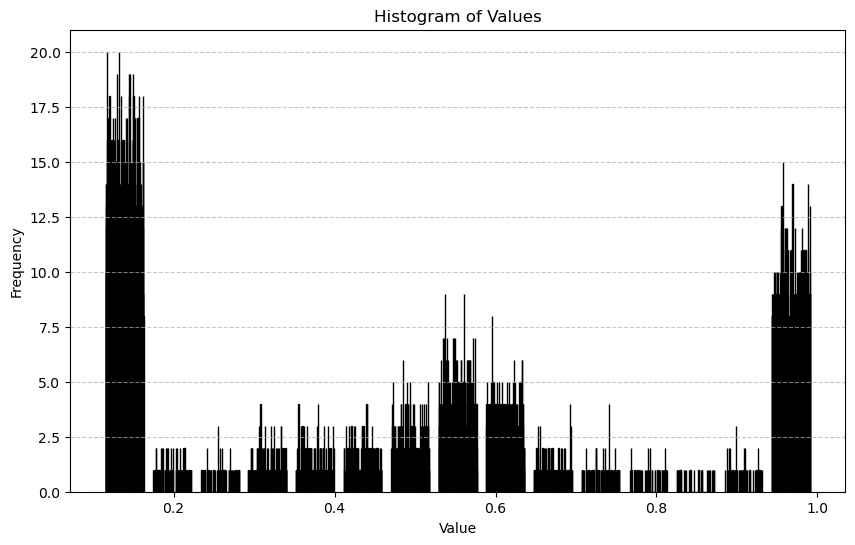

Epoch 1 - accuracy: 0.7520, val_accuracy: 0.7831


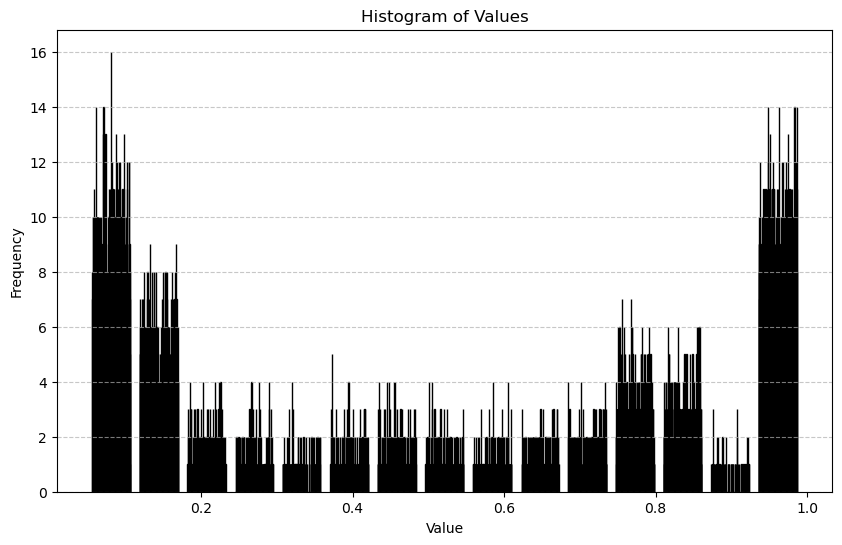

Epoch 2 - accuracy: 0.8199, val_accuracy: 0.8533


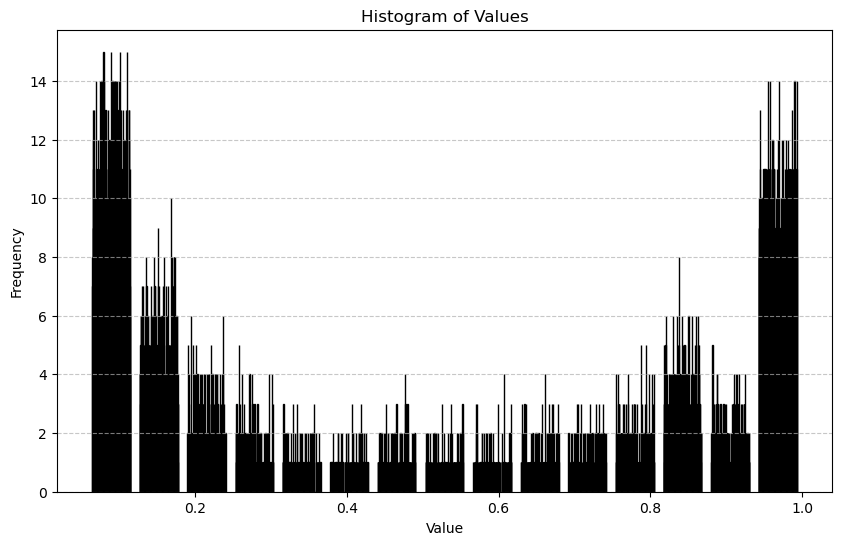

Epoch 3 - accuracy: 0.8448, val_accuracy: 0.8628


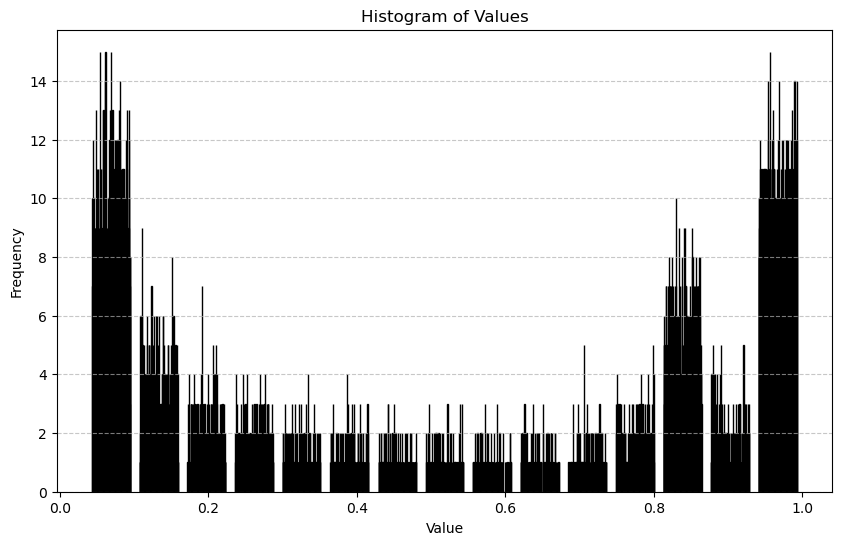

Epoch 4 - accuracy: 0.8730, val_accuracy: 0.8762


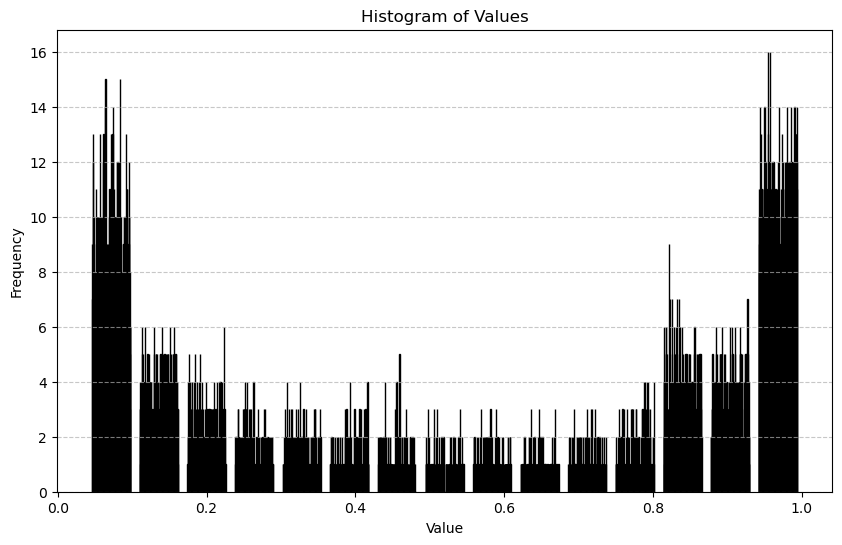

Epoch 5 - accuracy: 0.8876, val_accuracy: 0.8806


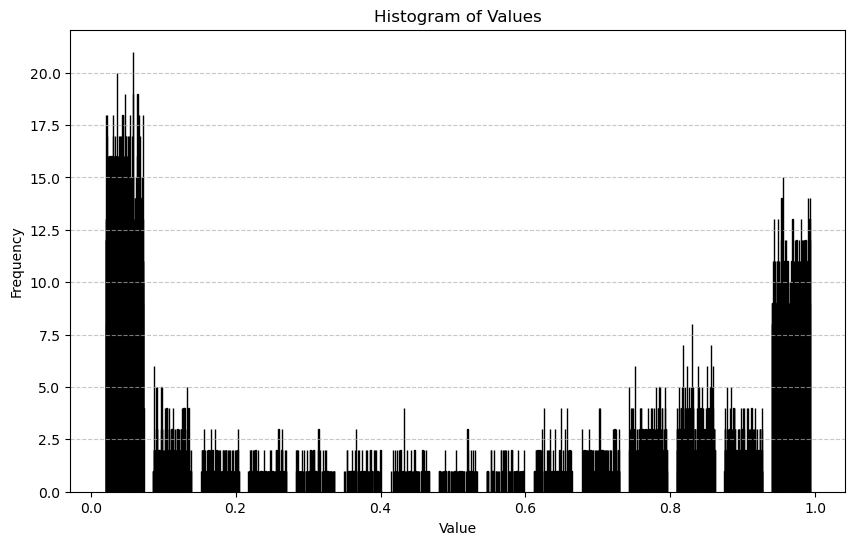

Epoch 6 - accuracy: 0.8919, val_accuracy: 0.8870


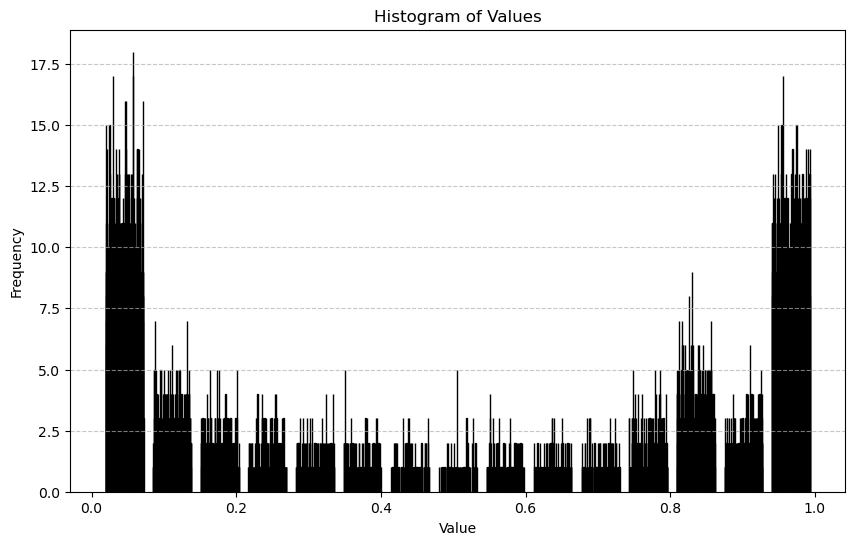

Epoch 7 - accuracy: 0.8977, val_accuracy: 0.8895


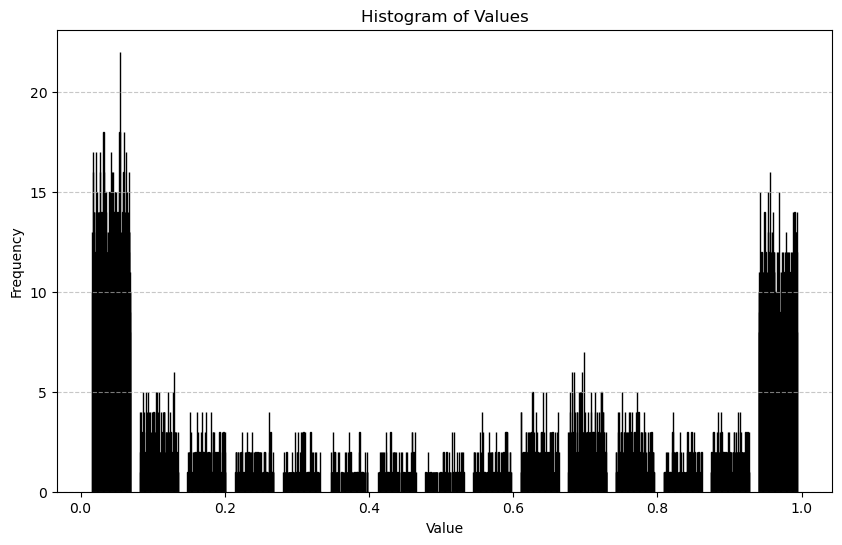

Epoch 8 - accuracy: 0.8994, val_accuracy: 0.8928


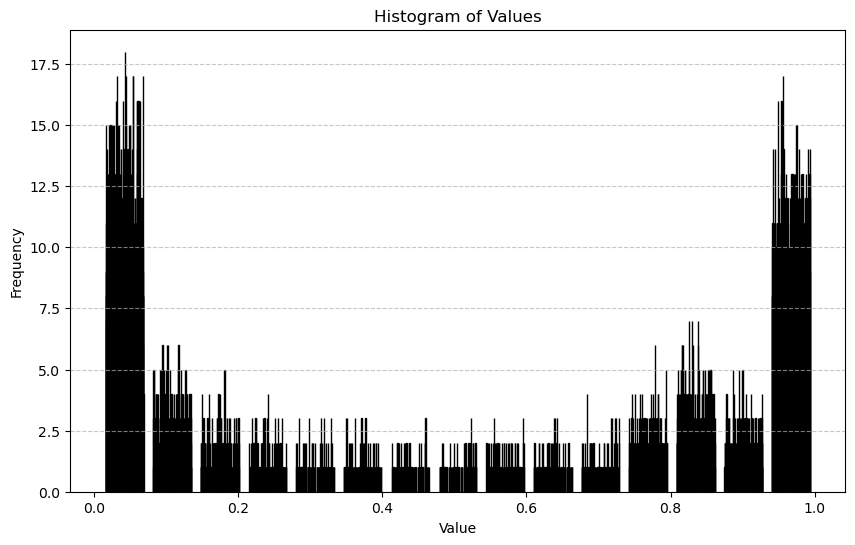

Epoch 9 - accuracy: 0.9008, val_accuracy: 0.8942


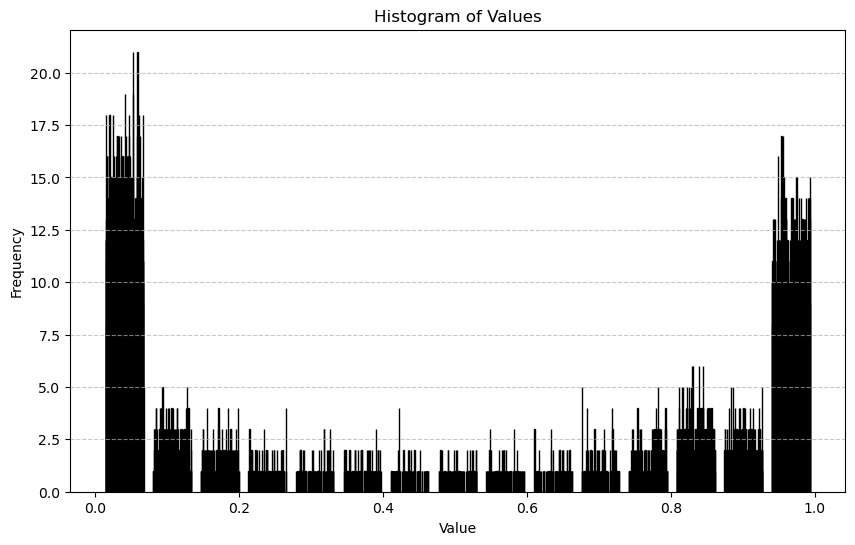

Epoch 10 - accuracy: 0.9017, val_accuracy: 0.8894


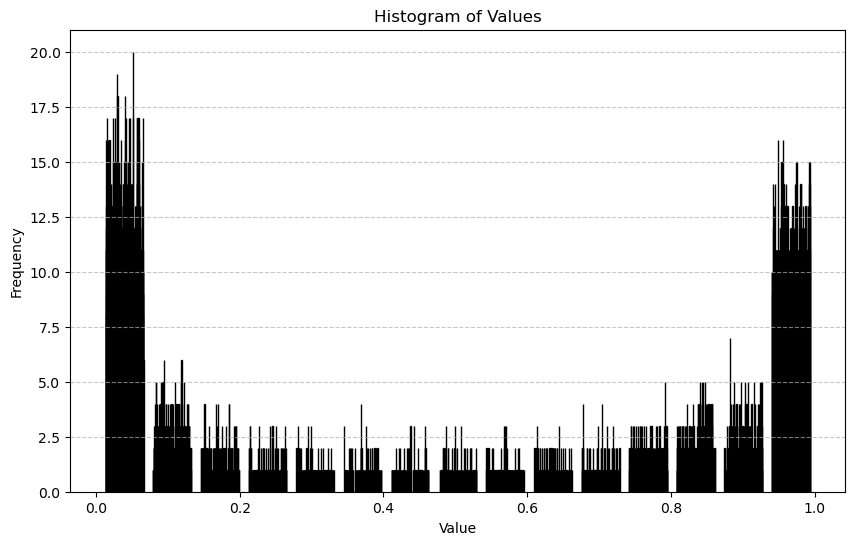

Epoch 11 - accuracy: 0.8783, val_accuracy: 0.8838


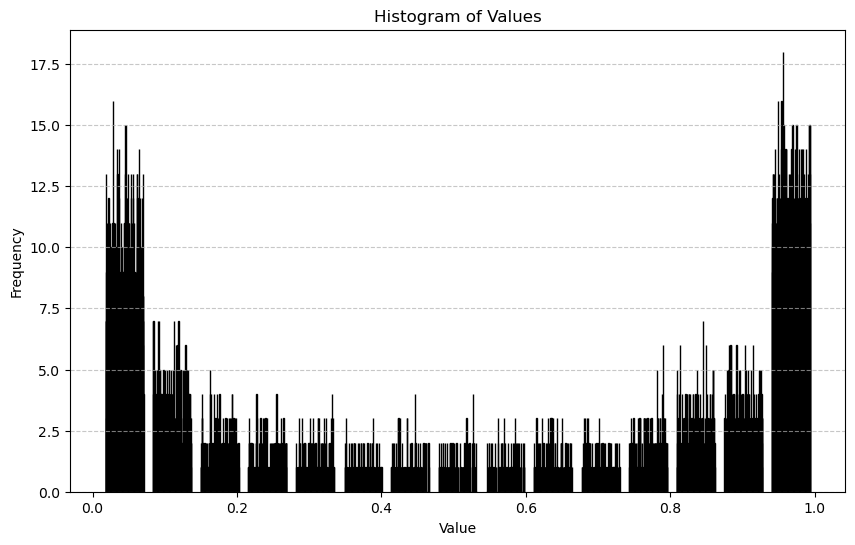

Epoch 12 - accuracy: 0.8967, val_accuracy: 0.8864


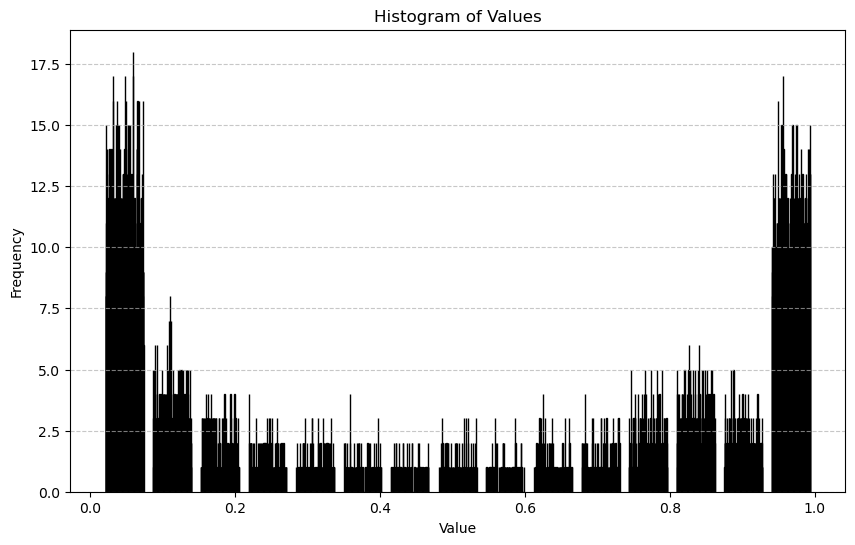

Epoch 13 - accuracy: 0.9013, val_accuracy: 0.8918


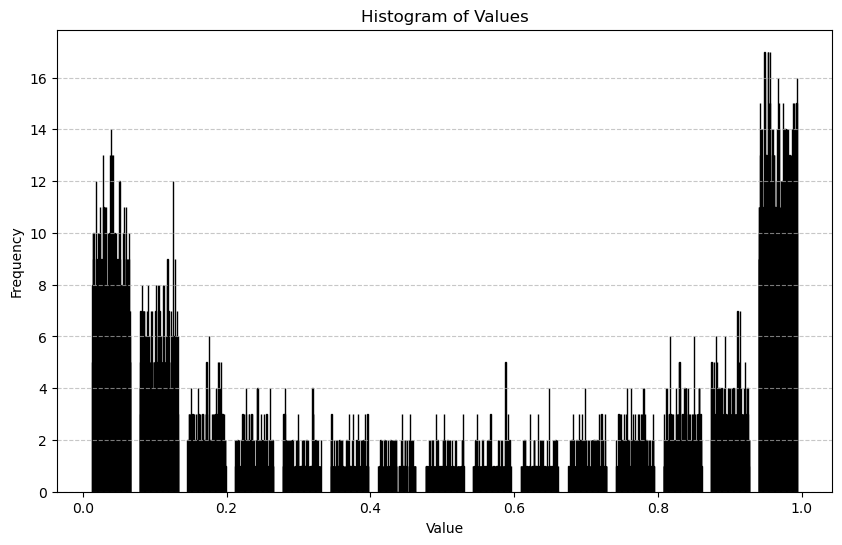

Epoch 14 - accuracy: 0.9025, val_accuracy: 0.8850


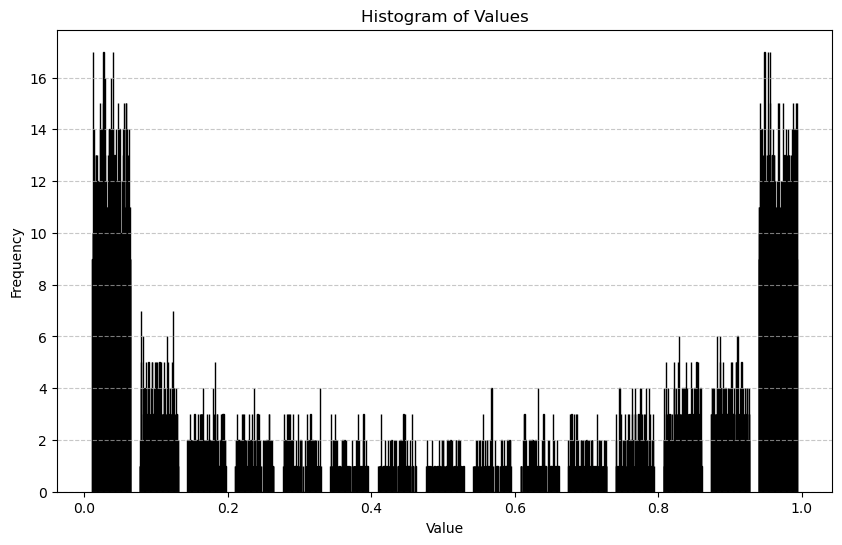

Epoch 15 - accuracy: 0.9051, val_accuracy: 0.8855


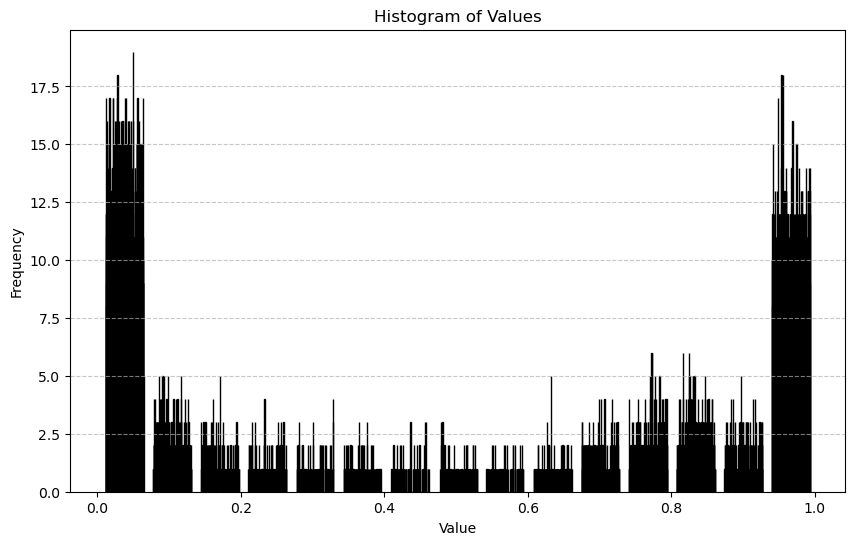

Epoch 16 - accuracy: 0.9056, val_accuracy: 0.8903


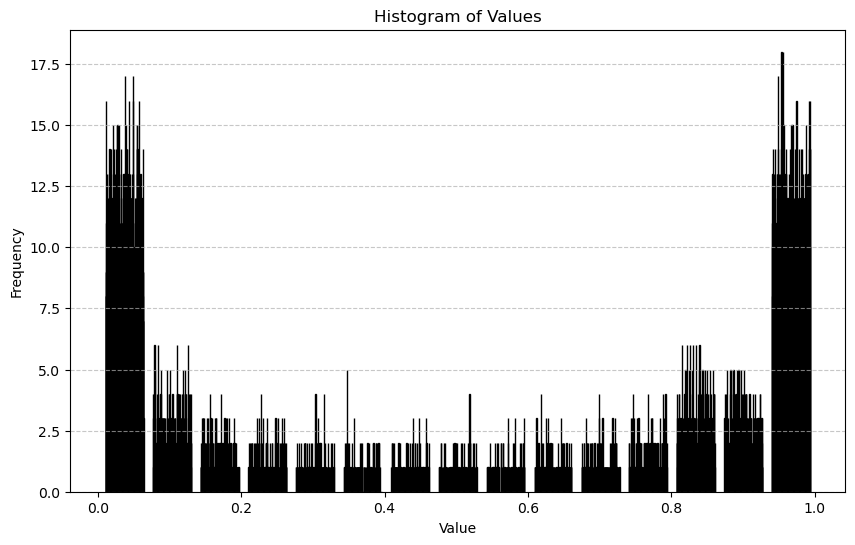

Epoch 17 - accuracy: 0.9068, val_accuracy: 0.8886


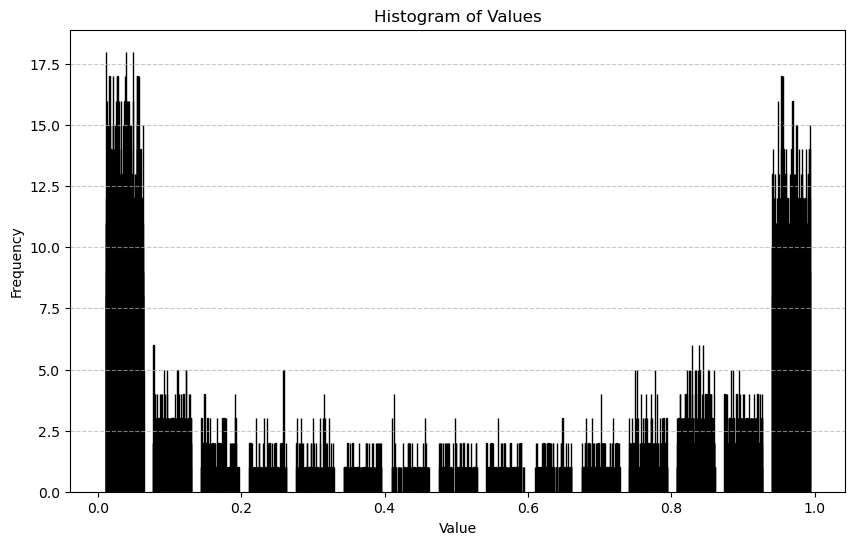

Epoch 18 - accuracy: 0.9084, val_accuracy: 0.8903


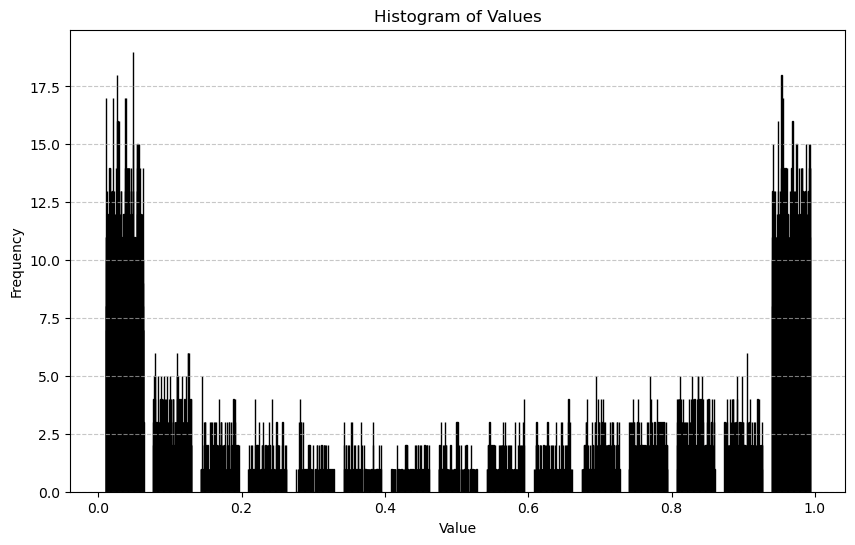

Epoch 19 - accuracy: 0.9109, val_accuracy: 0.8868


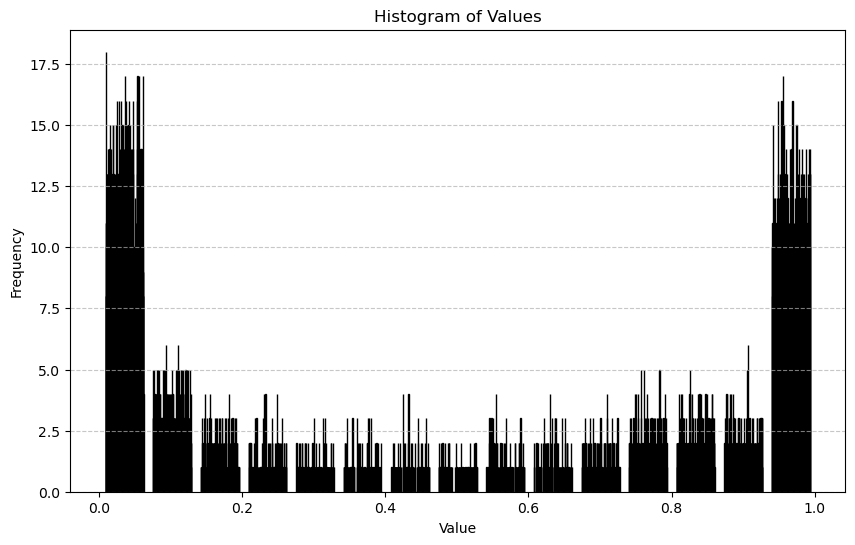

Epoch 20 - accuracy: 0.9123, val_accuracy: 0.8904


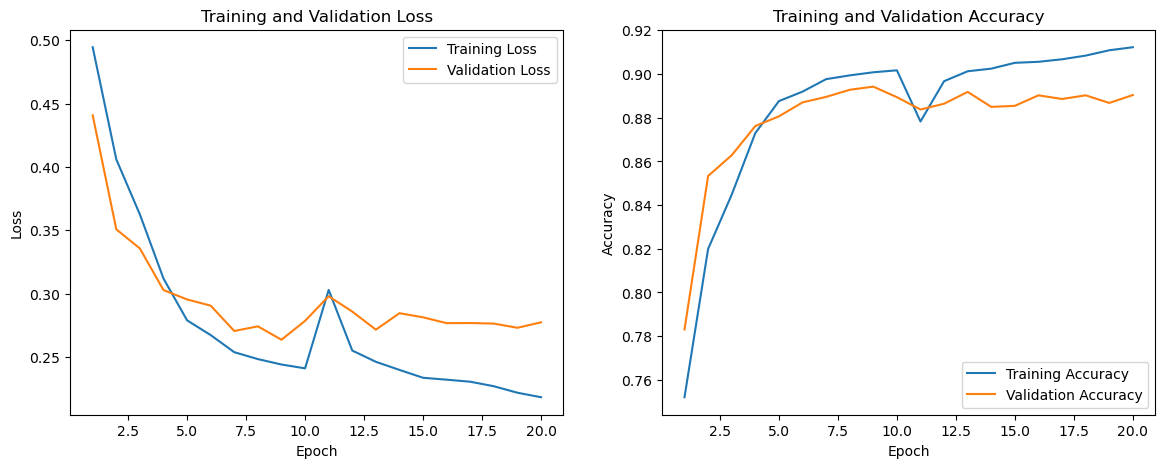

In [18]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Initialize lists to store training and validation metrics for each epoch
train_accuracies = []
train_losses = []
valid_accuracies = []
valid_losses = []

num_epochs = 20
torch.manual_seed(1)

# Training loop with metrics storage
for epoch in range(num_epochs):
    acc_train, loss_train = train(train_dl)
    acc_valid, loss_valid = evaluate(val_dl)
    
    # Store metrics
    train_accuracies.append(acc_train)
    train_losses.append(loss_train)
    valid_accuracies.append(acc_valid)
    valid_losses.append(loss_valid)

    print(f'Epoch {epoch + 1} - accuracy: {acc_train:.4f}, val_accuracy: {acc_valid:.4f}')

# Plotting training and validation losses
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig('images/lstm-accuracy.png')
plt.show()

In [19]:
# acc_test, _ = evaluate(test_dl)
# print(f'test_accuracy: {acc_test:.4f}')

In [20]:
import pandas as pd
import torch
import random

# Function to preprocess and predict a single account
def predict_comment(text, model, vocab):
    model.eval()
    # Tokenize and encode the input text using the same tokenizer and vocab as used during training
    tokens = tokenizer(text)
    encoded_text = [vocab.get(token, vocab["<unk>"]) for token in tokens]

    # Convert the tokens to tensor and add batch dimension
    text_tensor = torch.tensor(encoded_text).unsqueeze(0).to(device)  # Add batch dimension
    lengths_tensor = torch.tensor([len(encoded_text)]).to(device)

    with torch.no_grad():
        prediction = model(text_tensor, lengths_tensor)[:, 0]

    # Apply threshold of 0.5 for binary classification
    prediction_label = 1 if prediction >= 0.5 else 0
    return prediction.item(), prediction_label

# List to store prediction results
results = []

# Iterate over all samples in the test dataset
for sample in test_dataset:
    account_string = sample['text']
    true_label = sample['label']
    predicted_value, predicted_label = predict_comment(account_string, model, vocab)

    # Append the data for each comment
    results.append({
        "comment": account_string,
        "true_label": true_label,
        "predicted_value": predicted_value,
        "predicted_label": predicted_label
    })

# Convert results list to a DataFrame
results_df = pd.DataFrame(results)

# Save the results DataFrame to a CSV file
#given the path from job
# results_df.to_csv("./rnn/only_action_method/results/predictions-both.csv", index=False)

print("Results saved to predictions.csv")

Results saved to predictions.csv


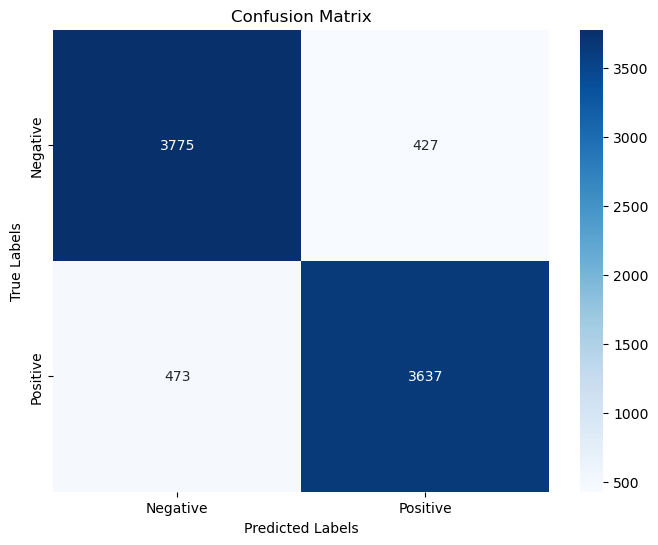

In [21]:
# Confusion matrix on the validation set
all_preds = []
all_labels = []

# Collect predictions and true labels from the validation set
for sample in test_dataset:
    account_string = sample['text']
    true_label = sample['label']
    predicted_value, predicted_label = predict_comment(account_string, model, vocab)  # Adjust if predict_comment takes a batch
    all_preds.append(predicted_label)
    all_labels.append(true_label)

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('images/lstm-confusion.png')
plt.show()

In [22]:
# #given the path from job
# results_df[results_df['true_label'] != results_df['predicted_label']].to_csv("./rnn/only_action_method/results/mismatches-both.csv")
# results_df.shape

In [26]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size,
                                      embed_dim,
                                      padding_idx=0)
        self.rnn = nn.LSTM(embed_dim, rnn_hidden_size,
                           batch_first=True)
        self.fc1 = nn.Linear(rnn_hidden_size, fc_hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text, lengths):
        # Step 1: Embedding layer
        out = self.embedding(text)
        print(f"After embedding: {out.shape}")
    
        # Step 2: Pack padded sequence
        packed_out = nn.utils.rnn.pack_padded_sequence(out, lengths.cpu().numpy(), enforce_sorted=False, batch_first=True)
        print(f"After packing: {packed_out.data.shape}")
    
        # Step 3: RNN (LSTM) layer
        packed_out, (hidden, cell) = self.rnn(packed_out)
        print(f"Hidden shape: {hidden.shape}")
        print(f"Cell shape: {cell.shape}")
    
        # Take the last hidden state
        out = hidden[-1, :, :]
        print(f"After selecting last hidden state: {out.shape}")
    
        # Step 4: First fully connected (Linear) layer
        out = self.fc1(out)
        print(f"After fc1: {out.shape}")
    
        # Step 5: ReLU activation
        out = self.relu(out)
        print(f"After ReLU: {out.shape}")
    
        # Step 6: Second fully connected (Linear) layer
        out = self.fc2(out)
        print(f"After fc2: {out.shape}")
    
        # Step 7: Sigmoid activation
        out = self.sigmoid(out)
        print(f"After sigmoid: {out.shape}")
    
        return out

vocab_size = len(vocab)
embed_dim = 20
rnn_hidden_size = 64
fc_hidden_size = 64

torch.manual_seed(1)
model = RNN(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size)
print(model)
model = model.to(device)

RNN(
  (embedding): Embedding(4795, 20, padding_idx=0)
  (rnn): LSTM(20, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [29]:
#-----  Example usage with DataLoader -----#
## Take a small batch

dataloader = DataLoader(train_dataset, batch_size=4, shuffle=False, collate_fn=collate_batch)
text_batch, label_batch, length_batch = next(iter(dataloader))

# Print the output batch
# print("Text batch:", text_batch)
print("Label batch:", label_batch)
print("Length batch:", length_batch)
print("Text batch shape:", text_batch.shape)

Label batch: tensor([0., 1., 0., 0.], device='cuda:0')
Length batch: tensor([300,  79, 300, 202], device='cuda:0')
Text batch shape: torch.Size([4, 300])


In [30]:
# Sample input data
import torch
import torch.nn as nn

# Initialize the model and move to device
model = RNN(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size).to(device)

# Forward pass
output = model(text_batch, length_batch)
print(f"Final output: {output}")


After embedding: torch.Size([4, 300, 20])
After packing: torch.Size([881, 20])
Hidden shape: torch.Size([1, 4, 64])
Cell shape: torch.Size([1, 4, 64])
After selecting last hidden state: torch.Size([4, 64])
After fc1: torch.Size([4, 64])
After ReLU: torch.Size([4, 64])
After fc2: torch.Size([4, 1])
After sigmoid: torch.Size([4, 1])
Final output: tensor([[0.4781],
        [0.4768],
        [0.4780],
        [0.4720]], device='cuda:0', grad_fn=<SigmoidBackward0>)
